# COMP47590: Advanced Machine Learning
# Assignment 1: Implementing Perceptrons

- Student 1 Name: Carl Fabian Winkler
- Student 1 Number: 20207528
- Student 2 Name: David Moreno Boras
- Student 2 Number: 21200646

## Introduction

This is an implementation based on NumPy implementation for a multi-layer perceptron (MLP). In the course Connectionist Computing at UCD we already implemented an MLP from scratch as an assignment. Our projects in C++ and Python can be viewed here:

- Carls CPP MLP: https://github.com/Chipato1/NeuralNetCPP
- Davids Python MLP: https://github.com/mbdavid2/multi-layer-perceptron

With this background, we are focusing on making this project more performant and modular. The goal is to make perceptron easily trainable and very performant. Therefore it should be easy to fit it to new data and selected the hyperparameters. All mathematical transformations should be optimized with NumPy operations. We divided the code into a class "Layer" which combines all functions that take part within a layer and a class "PerceptronClassifier" which should be accessible from outside and combine the logic to train the estimator. Furthermore, we aim to flexibly switch the batch size and to use different activations.

## Import Packages

In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import neural_network
from sklearn import ensemble
from sklearn import tree
"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample"""

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import train_test_split\n\nfrom sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state\nfrom sklearn.utils.multiclass import unique_labels\nfrom sklearn import preprocessing\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.utils import resample'

## Task 1: The Perceptron Classifier
Define the PerceptronClassifier class

In [528]:
class Layer():
    """
    Parameters
        n_in            : Number of inputs
        n_out           : Number of outputs
        activation      : The activation function: Sigmoid, ReLu, TanH
        init            : The init, currently only Xavier
        output_layer    : If this param is set the deriv. for the activation is not calculated in the backward pass
        
    Attributes
        weights: The weights are learnable parameters of the class 
        biases : Biases add a static offset for each neuron
        
    See also
        Class Perceptron
            - This class uses instances of this class to create an estimator
    """
    def __init__(self, n_in, n_out, activation = 'Sigmoid', init = 'Xavier', output_layer = False):
        # XW + b = y
        self.activation = activation
        self.output_layer = output_layer
        self.weights = np.zeros((n_in, n_out))
        self.biases = np.zeros((n_out))
        
        # Initialization is done through Xavier
        if init == 'Xavier':
            var = np.sqrt(6.0 / (n_in + n_out))
            for i in range(n_in):
                for j in range(n_out):
                      self.weights[i,j] = np.float32(np.random.uniform(-var, var))
                        
        self.d_w = np.zeros(weights.shape)
        self.d_b = np.zeros(biases.shape)

    # The forward pass consists of an affine transformation of the data and a non-linear activation per neuron
    def forward(self, x):
        z = x @ self.weights + self.biases
        
        if self.activation == 'Sigmoid':
            out = 1 / (1 + np.exp(-z))
        elif self.activation == 'ReLu':
            out = np.maximum(z, 0)
        elif self.activation == 'TanH':
            out = np.tanh(z)
        else:
            out = z
        
        self.cache = (x, z)
        return out    
    
    # The backward pass through the activation and the affine transformation
    def backward(self, d_out):
        inputs, z = self.cache
        weight = self.weights
        bias = self.biases

        if self.output_layer:
            d_act = z
        if self.activation == 'Sigmoid':
            d_act = d_out * (1 / (1 + np.exp(-z))) * (1 - 1 / (1 + np.exp(-z)))
        elif self.activation == 'ReLu':
            d_act = d_out * (z > 0)
            
        elif self.activation == 'TanH':
            d_act = d_out * np.square(z)
        else:
            d_act = z
   
        d_inputs = d_act @ weight.T
        self.d_w = inputs.T @ d_act
        self.d_b = d_act.sum(axis=0) 
        
        return d_inputs
    
    # Gradient descent update with weight decay
    def update_gd_params(self, lr, weight_decay, batch_size):
        #print("Weight upd: ", self.d_w)
        self.weights = self.weights - lr * (self.d_w + ((2 *weight_decay)/batch_size) * self.weights)
        self.biases = self.biases - lr * self.d_b

class PerceptronClassifier(BaseEstimator, ClassifierMixin):
        
    """
    Parameters
        in_dim       : The number of features of the inputs
        out_dim      : The number of outputs
        hidden_units : The number of neurons in hidden units
        n_layers     : The number of extra hiddenlayers, The network always has an input and an output layer!
        activation   : The activation function: Sigmoid, ReLu, TanH
        learning_rate: The learning rate for gradient descent
        weight_decay : The factor for the weight decay / regression term
        epochs       : The number of epochs for the training
        batch_size   : The number of samples that are passed in an epoch

    Attributes
        
    Notes
        This implementation is based on the BaseEstimator class from sklearn.
        The number of samples for the fit function can be selected freely.
        The batchsize needs to be smaller than the number of samples.
        The Inputs should be arrays with the shape (N, in_dim) where N is the number of samples.
        
    See also
        - class Layer
            Implementation of the single layers of that perceptron

    """
    # Constructor for the classifier object
    def __init__(self, in_dim, out_dim, hidden_units, n_layers, activation = 'Sigmoid', 
                 learning_rate = 0.01, weight_decay = 0, epochs = 30, batch_size = 16):

        """Setup a Perceptron classifier - description above""" 
        # Initialise class variabels
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_units = hidden_units
        self.n_layers = n_layers
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_curve = []
        self.layers = []     
        
        # Init all layers, last needs to be marked to avoid backprop. of sigm. activation
        self.layers.append(Layer(in_dim, hidden_units, activation, 'Xavier'))
        for l in range(n_layers):
            self.layers.append(Layer(hidden_units, hidden_units, activation, 'Xavier'))
        self.layers.append(Layer(hidden_units, out_dim, activation, 'Xavier', output_layer = True))
        
    #return the loss_curve     
    def get_losscurve(self):
        return self.loss_curve
    
    # Pass some inputs through the network
    def forward(self, X):
        out = self.layers[0].forward(X)
        for layer in self.layers[1:]:
            out = layer.forward(out)
        return out
    
    # Backward pass to go through all layers of the network with the upstream gradient           
    def backward(self, in_grad):
        i = len(self.layers) - 2 
        # d_inputs, _, _ = lay.backward(in_grad)
        next_grad = self.layers[i+1].backward(in_grad)
        while i >= 0:
            next_grad = self.layers[i].backward(next_grad)
            i -= 1 
            
    #compute the BCE loss, add an eps term to avoid numerical unstability       
    def bce_loss(self, ground, pred):
        eps = np.ones(len(ground))*0.00001
        return np.sum(ground* np.log(pred+eps) + (np.ones(len(ground))-ground)* np.log(np.ones(len(ground))-ground+eps))
        
    # Here we calculate the loss and give back the upstream gradient for BCE-Loss with Sigmoid activation       
    def loss_back(self, ground, pred):
        #l2_loss = np.sum(np.power(ground-np.squeeze(pred, axis=1), 2)) / len(ground)
        loss = bce_loss(ground, pred)
        upstream_grad = -np.expand_dims(ground-np.squeeze(pred),axis=1)
        return l2_loss, upstream_grad
        
    # The fit function to train a classifier
    def fit(self, X, y):
        for i in range(self.epochs):
            random_indices = np.random.choice(X.shape[0], size=self.batch_size, replace=False)
            x_batch = X[random_indices, :]
            y_batch = y[random_indices]
            
            out = self.forward(x_batch)            
            loss, grad = self.loss_back(y_batch, out)
            self.loss_curve.append(loss)
            
            # Backpropagation
            self.backward(grad)
            
            # Update weights and biases
            for layer in self.layers:
                layer.update_gd_params(self.learning_rate, self.weight_decay, self.batch_size)
                
        return
    
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        y_pred = self.forward(X)
        y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]
        return np.array(y_pred_binary)
    
    # The predict_proba function to make a set of predictions for a set of query instances. This returns a set of class distributions.
    def predict_proba(self, X):
        tmp = self.forward(X)
        sum1 = tmp.sum(axis = 1)
        out = X.T / sum1
        out = out.T
        return out

## Task 2: Evaluation

#### Load the Diabethic Retinopathy dataset
We normalize the data to support the classification. It is a simply min-max transformation to [0,1].

In [587]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

diabetic_af = pd.read_csv('messidor_features.csv', na_values='?', index_col = 0)
diabetic_af.head()
y = diabetic_af.pop('Class').values
x_raw = diabetic_af.values
x_norm = NormalizeData(x_raw)
y_numbers = list([int(x[2]) for x in y])
y_numbers = np.array(y_numbers)

x_train, x_test, y_train, y_test = train_test_split(x_norm, y_numbers, shuffle=False, train_size = 0.8)

x_train_n = NormalizeData(x_train)
x_test_n = NormalizeData(x_test)

#### Check the model
To make sure that our model is abled to learn and that it works properly we overfit on a very small part of the data. In this case we reach an accuracy of 100 %. The model therefore clearly has the ability to learn and the capacity to learn and even ovefit the data.

In [586]:
x_overfit = x_train_n[0:15]
y_overfit = y_train[0:15]

clf = PerceptronClassifier(len(x_train[0]), 1, 30, 1, learning_rate=0.5, epochs=10000,batch_size = 15)
clf.fit(x_overfit, y_overfit)
y_pred = clf.predict(x_overfit)
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]
accuracy = metrics.accuracy_score(y_pred_binary, y_overfit)
print('Accuracy of the overfitting-model is: ', accuracy)

Accuracy of the overfitting-model is:  1.0


#### Create a Baseline for the data
To have a model that the perceptron can be compared to a baseline model is created here. Therefore a perceptron model and an ensemble of decision tree modesl of the sklearn library is trained to the data. We are trying to reach or even be better than this baseline models in terms of accuracy with the perceptron implemented here. The sklearn MLP reaches an accuracy of 0.73 and the ensemble of decision tree reaches an accuracy of 0.64.

In [507]:
print("-------Sample SkLearn model: MLP Normalized---------")
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100), max_iter=1000, solver='adam')
my_model = my_model.fit(x_train_n, y_train)

# Make a set of predictions for the test data
y_pred = my_model.predict(x_test_n)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
# model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

-------Sample SkLearn model: MLP Normalized---------
Accuracy: 0.7310195227765727
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       221
           1       0.84      0.60      0.70       240

    accuracy                           0.73       461
   macro avg       0.75      0.74      0.73       461
weighted avg       0.76      0.73      0.73       461



In [422]:
print("-------Sample SkLearn model: Bagging Decision Tree Norm---------")
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model = my_model.fit(x_train_n, y_train)

# Make a set of predictions for the test data
y_pred = my_model.predict(x_test_n)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
# model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

-------Sample SkLearn model: Bagging Decision Tree Norm---------
Accuracy: 0.6442516268980477
              precision    recall  f1-score   support

           0       0.59      0.88      0.70       221
           1       0.79      0.43      0.56       240

    accuracy                           0.64       461
   macro avg       0.69      0.65      0.63       461
weighted avg       0.69      0.64      0.63       461



#### Training the perceptron
Now that the model can overfit some samples and two baseline models for the problem we start training the implemented perceptron on the data. We do a grid search over a huge space of different hyperparameters that the model supports. This keeps the computer busy for quite some time :) We do two grid searches here and take the best model. In the second grid search, we build upon the configuration that has shown to be good in the first search.

In [577]:
epochs = [15000,20000,25000]
hidden_units = [50, 70, 100, 120]
learning_rates = [0.1, 0.01, 0.005, 0.001]
batch_size = [32, 64,128]
hidden_layers = [0]
weight_decay = [0.00005,0.000005, 0]

param_grid ={'epochs': epochs, \
             'n_layers': hidden_layers, \
             'batch_size': batch_size, \
             'hidden_units': hidden_units, \
             'learning_rate': learning_rates, \
             'weight_decay': weight_decay}

cv_folds = 2

tuned_model = GridSearchCV(PerceptronClassifier(in_dim = len(x_train_n[0]), out_dim = 1, hidden_units = 30, \
                                                n_layers = 1, learning_rate=0.5, activation='Sigmoid'), \
                                param_grid, cv=cv_folds, verbose = 2, \
                                return_train_score=True, n_jobs = -1)

tuned_model.fit(x_train_n, y_train)
y_pred = tuned_model.predict(x_test_n)

accuracy = metrics.accuracy_score(y_pred, y_test)
print('Accuracy of the tuned model is: ', accuracy)
display(tuned_model.best_params_)

Fitting 2 folds for each of 432 candidates, totalling 864 fits
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.01, n_layers=0, weight_decay=5e-05; total time=   7.6s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.005, n_layers=0, weight_decay=5e-05; total time=   8.1s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.001, n_layers=0, weight_decay=5e-05; total time=   8.3s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.1, n_layers=0, weight_decay=5e-05; total time=   8.6s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.01, n_layers=0, weight_decay=0; total time=   9.6s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.001, n_layers=0, weight_decay=5e-05; total time=  10.1s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.1, n_layers=0, weight_decay=0; total time=   9.6s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learn

[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.1, n_layers=0, weight_decay=5e-06; total time=   7.4s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=   7.9s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.005, n_layers=0, weight_decay=0; total time=   8.6s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.1, n_layers=0, weight_decay=5e-05; total time=   8.3s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=   8.7s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.005, n_layers=0, weight_decay=0; total time=   9.0s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.1, n_layers=0, weight_decay=5e-05; total time=   9.5s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=   9.4s

[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.1, n_layers=0, weight_decay=0; total time=   7.5s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.01, n_layers=0, weight_decay=0; total time=   8.6s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.001, n_layers=0, weight_decay=5e-06; total time=   9.4s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.01, n_layers=0, weight_decay=5e-05; total time=   9.2s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=   9.2s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.001, n_layers=0, weight_decay=0; total time=   9.2s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.01, n_layers=0, weight_decay=5e-05; total time=   8.8s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.005, n_layers=0, weight_decay=5e-05; total time=   9.0s

[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.1, n_layers=0, weight_decay=0; total time=   8.0s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=   8.7s
[CV] END batch_size=32, epochs=15000, hidden_units=50, learning_rate=0.001, n_layers=0, weight_decay=0; total time=   9.2s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.01, n_layers=0, weight_decay=5e-05; total time=   9.3s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=   9.7s
[CV] END batch_size=32, epochs=15000, hidden_units=70, learning_rate=0.001, n_layers=0, weight_decay=0; total time=  10.1s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.01, n_layers=0, weight_decay=5e-05; total time=   9.7s
[CV] END batch_size=32, epochs=15000, hidden_units=100, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=  10.0

{'batch_size': 64,
 'epochs': 25000,
 'hidden_units': 100,
 'learning_rate': 0.1,
 'n_layers': 0,
 'weight_decay': 5e-05}

In [609]:
epochs = [40000, 50000]
hidden_units = [75, 100, 125]
learning_rates = [0.01,0.03,0.005]
batch_size = [32, 64]
hidden_layers = [0,1]
weight_decay = [0.000005,0]

param_grid ={'epochs': epochs, \
             'n_layers': hidden_layers, \
             'batch_size': batch_size, \
             'hidden_units': hidden_units, \
             'learning_rate': learning_rates, \
             'weight_decay': weight_decay}

cv_folds = 2

tuned_model = GridSearchCV(PerceptronClassifier(in_dim = len(x_train_n[0]), out_dim = 1, hidden_units = 30, \
                                                n_layers = 1, learning_rate=0.5, activation='Sigmoid'), \
                                param_grid, cv=cv_folds, verbose = 2, \
                                return_train_score=True, n_jobs = -1)

tuned_model.fit(x_train_n, y_train)
y_pred = tuned_model.predict(x_test_n)

accuracy = metrics.accuracy_score(y_pred, y_test)
print('Accuracy of the tuned model is: ', accuracy)
display(tuned_model.best_params_)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
Accuracy of the tuned model is:  0.7402597402597403


{'batch_size': 64,
 'epochs': 50000,
 'hidden_units': 100,
 'learning_rate': 0.03,
 'n_layers': 0,
 'weight_decay': 0}

In [614]:
# We do this again to train an optimal model and investigate the influence of the random-intialization.
# This model is performed several times
model = PerceptronClassifier(in_dim = len(x_train_n[0]), 
                             out_dim = 1, \
                             hidden_units = 100, \
                             batch_size = 64,\
                             n_layers = 0, \
                             epochs = 50000,\
                             weight_decay = 0, \
                             learning_rate= 0.03, \
                             activation='Sigmoid')

model.fit(x_train_n, y_train)
y_pred = model.predict(x_test_n)

accuracy = metrics.accuracy_score(y_pred, y_test)
print('Accuracy of the tuned model is: ', accuracy)
print(metrics.classification_report(y_test, y_pred))

Accuracy of the tuned model is:  0.7489177489177489
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       115
           1       0.76      0.72      0.74       116

    accuracy                           0.75       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.75      0.75      0.75       231

[CV] END batch_size=64, epochs=50000, hidden_units=210, learning_rate=0.05, n_layers=0, weight_decay=5e-06; total time=  35.9s
[CV] END batch_size=64, epochs=50000, hidden_units=100, learning_rate=0.5, n_layers=0, weight_decay=5e-06; total time=  28.1s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.01, n_layers=0, weight_decay=0; total time=  22.3s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.03, n_layers=1, weight_decay=0; total time=  23.3s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.005, n_layers=1, weight_decay=5e-06; total time=  24.

[CV] END batch_size=64, epochs=50000, hidden_units=210, learning_rate=0.05, n_layers=0, weight_decay=5e-06; total time=  35.5s
[CV] END batch_size=64, epochs=50000, hidden_units=100, learning_rate=1, n_layers=0, weight_decay=5e-06; total time=  26.7s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.01, n_layers=0, weight_decay=0; total time=  21.1s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.03, n_layers=0, weight_decay=5e-06; total time=  23.5s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=  24.1s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=  24.8s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.03, n_layers=0, weight_decay=5e-06; total time=  24.2s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=

[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.01, n_layers=1, weight_decay=0; total time=  21.3s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.03, n_layers=0, weight_decay=0; total time=  22.8s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=  24.4s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=  24.0s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.03, n_layers=0, weight_decay=5e-06; total time=  24.0s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.005, n_layers=0, weight_decay=5e-06; total time=  28.8s
[CV] END batch_size=32, epochs=40000, hidden_units=125, learning_rate=0.01, n_layers=0, weight_decay=0; total time=  24.2s
[CV] END batch_size=32, epochs=40000, hidden_units=125, learning_rate=0.03, n_layers=0, weight_decay=0; total time=  24.6s
[

[CV] END batch_size=64, epochs=50000, hidden_units=210, learning_rate=0.5, n_layers=0, weight_decay=5e-06; total time=  35.4s
[CV] END batch_size=64, epochs=50000, hidden_units=100, learning_rate=1, n_layers=0, weight_decay=5e-06; total time=  23.7s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.01, n_layers=0, weight_decay=5e-06; total time=  21.5s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.03, n_layers=0, weight_decay=5e-06; total time=  25.3s
[CV] END batch_size=32, epochs=40000, hidden_units=75, learning_rate=0.005, n_layers=1, weight_decay=0; total time=  25.0s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.01, n_layers=1, weight_decay=5e-06; total time=  24.9s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.03, n_layers=1, weight_decay=5e-06; total time=  25.1s
[CV] END batch_size=32, epochs=40000, hidden_units=100, learning_rate=0.005, n_layers=1, weight_decay=5e-06; total time= 

Text(0, 0.5, 'Loss')

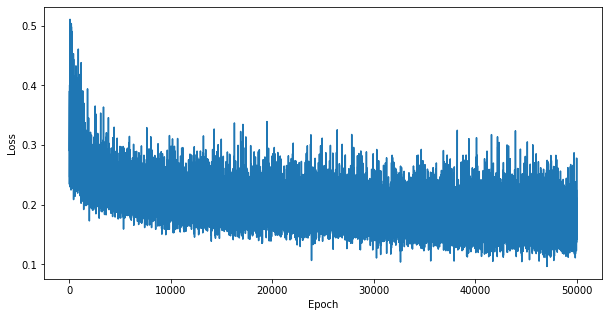

In [615]:
# Plot the loss-curve
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
loss = model.get_losscurve()
plt.plot(loss)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

## Task 3 & 4: Add Different Activations & Regularisation

Reimplement the PerceptronClassifier class adding an activation function option and L2 regularisation. Our model is structured modulary. This way we could directly introduce the capability to use regularisation and different activation functions. However for different activation function we only support the L2-Loss and not BCE-Loss which is less suited for this kind of problem and the task was deleted from this assignment. The implementation can be found in the class and we extensively evaluated the parts before.

## Task 5: Reflect on the Performance of the Different Models Evaluated

#### Comparison of models

The best model we trained reached an accuracy of 0.745 on the test data. This is slightly better than the MLP model from sklearn. Although we tried countless configurations we couldn't beat sklearn significantly. However, this implementation performs significantly better than the ensemble of decision trees. This can be explained by a higher capability of the MLP to generalize on complex interrelationships of the data. It predicts the data with around 10% more accuracy. The fact that the MLP from sklearn performs better can be explained by the usage of a better optimization algorithm. While this implementation uses a mini-batch vanilla gradient descent optimization method, the sklearn-model uses ADAM which allows it to reach better minima significantly faster. Furthermore, it is likely that our implementations depend more on the initialization of the weights. Furthermore, all models tend to assign more ones than zeros. The training set is only slightly misbalanced. This can therefore most likely not explain the effect.  In conclusion, our model reached a good accuracy and could be configured freely and the training is reasonably fast.

#### Training of the model and hyperparameters

During the training of the model, we found that most models first adapt to classifying all samples as 0 or 1. This can be seen in the loss curve as an initial plateau. Some models do not leave this plateau to the end of the epoch which is problematic. It showed that using a smaller batch size can help to overcome this plateau faster.

The hyperparameters of this model are highly dependent on each other. This makes it more difficult to find a good set of parameters. When the batch size gets smaller it tends to be beneficial to also decrease the learning rate. A smaller learning rate then tends to work well with an increased number of epochs and so on. Therefore, doing a grid search over a huge configuration, space really helped to find a good set of parameters. This is computationally intensive and therefore takes some time. On average a model to predict diabetes needs like 10s to train in our testing environment.

The weight decay has proven to be beneficial but with a very small scaling value. In the loss curve, it could be noticed that the weight decay tends to decrease the oscillations in the loss. In general, it seems that the influence of the weight decay is especially helpful when models get really high accuracy and get in danger to overfit the training data. In the best model, we trained so far the weight decay is 0. This could be explained by the danger of generalizing too much on the data. Due to the higher oscillations, the accuracy varies a lot if the model is trained again with the exact same parameters. Therefore, in general, weight decay will be beneficial to reliably reach a configuration that reliably predicts the data.

Our final model and its configuration can be seen in the cells above. Furthermore, we show the loss curve on the training data to illustrate how the model is trained. We use a relatively low batch size and train for many epochs. After a short swing to predicting 1 for all values, our model starts to predict the values of the test set more and more precisely.

#### Summary
In conclusion, the model can learn the diabetes dataset well and the model with the best configurations could reach an accuracy of 0.72 for the prediction on the test set. The weight decay has also proven to be useful to prevent overfitting in some models. In general, the task of finding a good hyperparameter set is very tedious and takes a lot of time. 

#### Limitations and Outlook
For further development of this implementation, we will try to implement a more sophisticated optimization method like ADAM. This should improve the convergence towards a good parameter-set. The major limitation of this implementation is that it still takes around 10s to train an average model for our problem. This is significantly slower than with libraries like Pytorch. To improve this it could be considered to do the matrix operations on the GPU of the computer.